# 📈 Evaluación del Modelo Final (Métricas y Gráficos)

## 🎯 Objetivo
En este notebook evaluamos el rendimiento del modelo seleccionado (`best_pipeline.pkl`) utilizando datos no vistos (o un subconjunto de validación).
Analizamos métricas clave para clasificación binaria en el contexto médico.

## 📊 Métricas Principales
- **Matriz de Confusión**: ¿Cuántos enfermos detectamos correctamente (TP) y cuántos sanos alarmamos falsamente (FP)?
- **Recall (Sensibilidad)**: Capacidad del modelo para identificar positivos. Es nuestra prioridad.
- **Precision**: De los que el modelo dice que están enfermos, ¿cuántos lo están realmente?
- **F1-Score**: Balance armónico entre Precision y Recall.
- **AUC-ROC**: Capacidad discriminante global del modelo.

## 🔍 Interpretabilidad
- **Feature Importance**: ¿Qué biomarcadores (Edad, Glucosa, Presión) influyen más en la predicción?

### 🔹 Paso 1: Importación de Herramientas de Evaluación
Importamos las librerías necesarias para la evaluación post-entrenamiento:
- **Scikit-learn metrics**: Para calcular matrices de confusión, reportes de clasificación y curvas ROC.
- **Seaborn/Matplotlib**: Para graficar visualmente los resultados.
- **PyCaret**: Para cargar el modelo entrenado.

In [1]:
import pandas as pd
from pycaret.classification import *
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
import os
import json

# ==========================================
# CONFIGURATION
# ==========================================
MODEL_PATH = "../models/best_pipeline"
DATA_PATH = "../data/02_intermediate/process_data.parquet"
CONFIG_PATH = "../models/model_config.json"


## 1. Carga del Modelo y Datos de Prueba

### 🔹 Paso 2: Carga del Modelo y Datos de Prueba
Recuperamos el artefacto del modelo (`best_pipeline.pkl`) que guardamos en la fase de entrenamiento.
También cargamos una muestra fresca de datos (`df_eval`) para simular un entorno de producción y verificar cómo se comporta el modelo con datos que (idealmente) no ha visto durante el entrenamiento.

In [2]:
# ==========================================
# 1. LOAD MODEL & DATA
# ==========================================
pipeline = load_model(MODEL_PATH)

# Load Data for Evaluation
df = pd.read_parquet(DATA_PATH)

with open(CONFIG_PATH, 'r') as f:
    config = json.load(f)

# Use a sample for quick evaluation if dataset is huge
df_eval = df.sample(frac=0.2, random_state=123) 
print(f"Evaluation Data Shape: {df_eval.shape}")


Transformation Pipeline and Model Successfully Loaded
Evaluation Data Shape: (8739, 28)


## 2. Generación de Predicciones
Aplicamos el modelo sobre el set de evaluación para obtener etiquetas y probabilidades.

### 🔹 Paso 3: Generación de Predicciones
Utilizamos la función `predict_model` para pasar los datos de evaluación a través del pipeline.
Esto genera un DataFrame con dos columnas nuevas:
- `prediction_label`: La clase predicha (0 o 1).
- `prediction_score`: La probabilidad o confianza de la predicción.

In [3]:
# ==========================================
# 2. GENERATE PREDICTIONS
# ==========================================
predictions = predict_model(pipeline, data=df_eval)
# PyCaret appends 'prediction_label' and 'prediction_score'
print(predictions.head())


           SEQN  Sex   Age  Race  Education  IncomeRatio  SystolicBP  \
37199   65151.0  2.0  26.0   1.0        3.0         2.16  110.666664   
21893   90930.0  2.0  76.0   4.0        5.0         5.00  138.666672   
9621   119261.0  1.0  20.0   3.0        3.0         0.96  121.666664   
15321   84083.0  1.0   5.0   5.0        NaN         1.65         NaN   
24535   93677.0  2.0  34.0   3.0        5.0         1.76  113.333336   

             BMI  WaistCircumference      Height  ...  Sodium  GGT_Enzyme  \
37199  36.500000          112.900002  160.500000  ...   140.0        30.0   
21893  33.000000          111.400002  165.199997  ...   141.0        18.0   
9621   38.599998          125.300003  188.300003  ...   141.0        18.0   
15321        NaN                 NaN         NaN  ...     NaN         NaN   
24535  22.200001           83.300003  167.399994  ...   140.0        14.0   

       AST_Enzyme  Smoking  PhysicalActivity  HealthInsurance  Alcohol  \
37199        21.0      1.0    

## 3. Análisis de Errores (Matriz de Confusión)
Visualizamos la distribución de aciertos y fallos. Nos interesa minimizar los Falsos Negativos (pacientes enfermos diagnosticados como sanos).

### 🔹 Paso 4: Visualización de la Matriz de Confusión
Generamos y graficamos la **Matriz de Confusión**.
Esta herramienta es fundamental para desglosar los errores:
- **TP (Verdaderos Positivos)**: Enfermos correctamente identificados.
- **FN (Falsos Negativos)**: Enfermos no detectados (El error más peligroso en medicina).
- **FP (Falsos Positivos)**: Sanos diagnosticados erróneamente.
- **TN (Verdaderos Negativos)**: Sanos correctamente identificados.

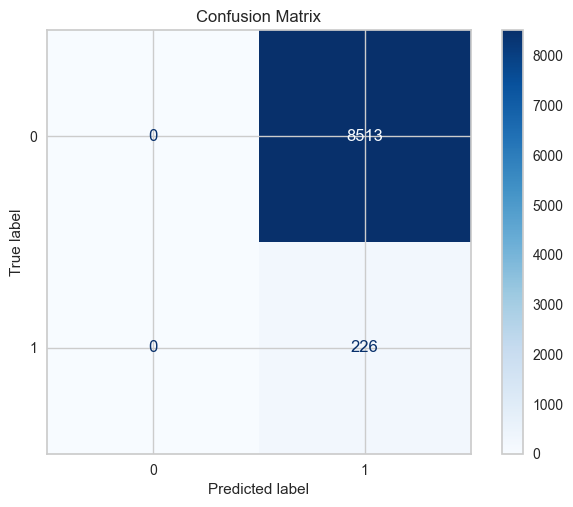

In [4]:
# ==========================================
# 3. CONFUSION MATRIX
# ==========================================
y_true = predictions[config['target']]
y_pred = predictions['prediction_label']

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


## 4. Métricas de Desempeño
- **Recall**: Crítico para tamizaje médico.
- **AUC**: Medida de separabilidad entre clases.

### 🔹 Paso 5: Reporte Métrico Detallado (Recall, AUC)
Imprimimos el `classification_report` completo y calculamos el **AUC-ROC**.
- Nos enfocamos en la métrica **Recall** para la clase 1 (Enfermedad). Un Recall alto indica que estamos capturando la mayoría de los casos positivos.
- El **AUC** nos da una medida de qué tan bien el modelo separa las dos clases independientemente del umbral de decisión.

In [5]:
# ==========================================
# 4. METRICS REPORT
# ==========================================
print("Classification Report:")
print(classification_report(y_true, y_pred))

try:
    # Calculate AUC if scores are available
    # prediction_score is the probability of the predicted class. 
    # For AUC we need probability of the positive class.
    # PyCaret's prediction_score is max(prob_0, prob_1). 
    # We assume binary classification 0/1.
    # If label is 1, prob_1 = score. If label is 0, prob_1 = 1 - score.
    
    probs = predictions.apply(lambda x: x['prediction_score'] if x['prediction_label'] == 1 else 1 - x['prediction_score'], axis=1)
    auc = roc_auc_score(y_true, probs)
    print(f"ROC AUC Score: {auc:.4f}")
except Exception as e:
    print(f"AUC Calculation Warning: {e}")


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      8513
           1       0.03      1.00      0.05       226

    accuracy                           0.03      8739
   macro avg       0.01      0.50      0.03      8739
weighted avg       0.00      0.03      0.00      8739

ROC AUC Score: 0.8486


## 5. Explicabilidad del Modelo
Identificamos los factores de riesgo más importantes según el modelo aprendido.

### 🔹 Paso 6: Importancia de Variables (Feature Importance)
Analizamos qué variables tienen más peso en las decisiones del modelo.
Utilizamos `plot_model` de PyCaret o extraemos manualmente las `feature_importances_`.
Esto nos ayuda a validar la coherencia clínica del modelo: esperamos ver variables como Edad, Presión Sistólica o Colesterol en los primeros lugares.

PyCaret plot_model failed or not supported for this pipeline. Attempting manual plot.


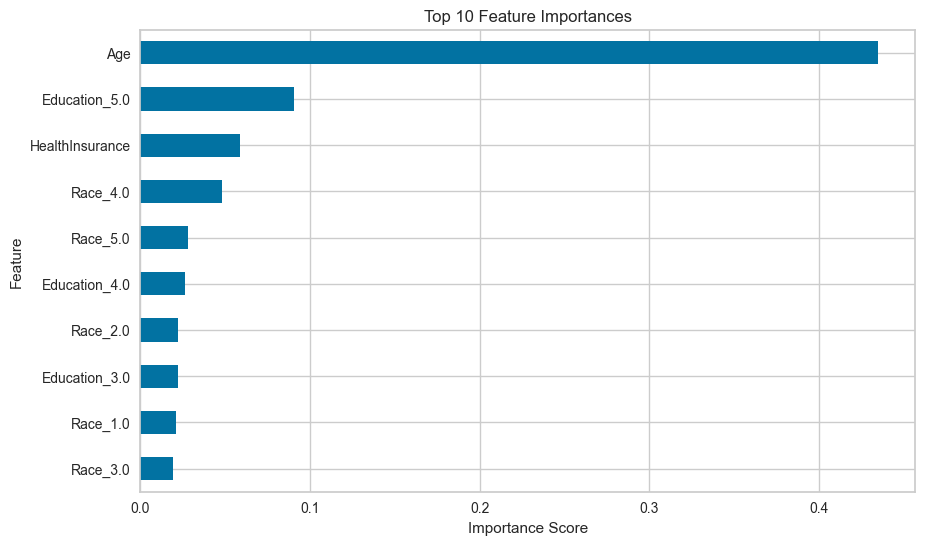


📊 Top 10 Feature Importances:
Age                0.435176
Education_5.0      0.090599
HealthInsurance    0.059005
Race_4.0           0.048238
Race_5.0           0.028337
Education_4.0      0.026349
Race_2.0           0.022269
Education_3.0      0.021918
Race_1.0           0.020763
Race_3.0           0.018965


In [6]:
# ==========================================
# 5. FEATURE IMPORTANCE
# ==========================================
# Attempt to plot feature importance using PyCaret or extraction
try:
    plot_model(pipeline, plot='feature')
except:
    print("PyCaret plot_model failed or not supported for this pipeline. Attempting manual plot.")
    try:
        # Extract model from pipeline (usually the last step)
        model_step = pipeline.steps[-1][1]
        if hasattr(model_step, 'feature_importances_'):
            feature_names = None
            
            # Method 1: Check if the model itself has feature_names_in_ (Most Reliable)
            if hasattr(model_step, 'feature_names_in_'):
                feature_names = model_step.feature_names_in_.tolist()
            
            # Method 2: Try get_feature_names_out from pipeline
            if feature_names is None:
                try:
                    feature_names = pipeline[:-1].get_feature_names_out(input_features=config['features'])
                except:
                    pass

            # Method 3: Transform data sample to get columns
            if feature_names is None:
                try:
                    # Create a small sample without target
                    X_sample = df_eval.drop(columns=[config['target']]).head()
                    # Transform using the pipeline excluding the final model
                    X_transformed = pipeline[:-1].transform(X_sample)
                    if hasattr(X_transformed, 'columns'):
                        feature_names = X_transformed.columns.tolist()
                except Exception as e:
                    print(f"Method 3 (Transform) failed: {e}")

            # Debugging Mismatch
            if feature_names is not None and len(feature_names) != len(model_step.feature_importances_):
                print(f"⚠️ Mismatch detected! Features: {len(feature_names)}, Importances: {len(model_step.feature_importances_)}")
                print(f"Features: {feature_names}")
                # Fallback to generic if mismatch persists to avoid crash
                feature_names = [f"Feature_{i}" for i in range(len(model_step.feature_importances_))]

            # Fallback
            if feature_names is None:
                feature_names = [f"Feature_{i}" for i in range(len(model_step.feature_importances_))]
            
            # Create Series
            importances = pd.Series(model_step.feature_importances_, index=feature_names)
            
            # --- PLOT ---
            plt.figure(figsize=(10, 6))
            importances.nlargest(10).plot(kind='barh', title='Top 10 Feature Importances')
            plt.xlabel('Importance Score')
            plt.ylabel('Feature')
            plt.gca().invert_yaxis() # Highest importance at top
            plt.show()
            
            # --- TEXT OUTPUT ---
            print("\n📊 Top 10 Feature Importances:")
            print(importances.nlargest(10).to_string())
            
    except Exception as e:
        print(f"Manual feature importance plot failed: {e}")
